In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astroML.density_estimation import EmpiricalDistribution
from scipy.optimize import NonlinearConstraint, Bounds, differential_evolution
from IPython.display import clear_output
import traceback
import matplotlib.font_manager
import pickle

from Utilities import plots
from Utilities import processing
from Utilities import model_evaluation
from Utilities import optim_fun

# Load data

In [20]:
mean_p = pd.read_csv(r'Experiments\Surrogate modeling\Data\mean_prices.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
mean_p.columns.name='days'
mean_p.columns=mean_p.columns.astype(int)
mean_d = pd.read_csv(r'Experiments\Surrogate modeling\Data\mean_demand.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
mean_d.columns.name='days'
mean_d.columns=mean_d.columns.astype(int)

prices = pd.read_csv(r'Experiments\Surrogate modeling\Data\prices.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
prices.columns.name='days'
prices.columns=prices.columns.astype(int)
demand = pd.read_csv(r'Experiments\Surrogate modeling\Data\demand.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
demand.columns.name='days'
places = pd.read_csv(r'Experiments\Surrogate modeling\Data\places.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
places.columns.name='days'
places.columns=places.columns.astype(int)

prices_cons = pd.read_csv(r'Experiments\Surrogate modeling\Data\prices_cons.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
prices_cons.columns.name='days'
prices_cons.columns=prices_cons.columns.astype(int)

with open(r'Experiments\Surrogate modeling\Data\uniq_train_num.data', 'rb') as f:  
    uniq_train_num = pickle.load(f)
    
with open(r'Experiments\Surrogate modeling\Data\wk_days_mask.data', 'rb') as f:  
    wk_days_mask = pickle.load(f)

# Surrogate modeling

## Data linearization and Box Cox Transformation

In [3]:
%%time

log_lin_prices=pd.DataFrame(data=None, columns=prices.columns, index=prices.index, dtype="float")
lin_prices=pd.DataFrame(data=None, columns=prices.columns, index=prices.index, dtype="float")
log_shift_demand=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float")
shift_demand=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float")

list_ind=list(zip(sorted(np.array([uniq_train_num]*len(wk_days_mask)).ravel()), \
                  (wk_days_mask)*len(uniq_train_num)))
mu_ind=pd.MultiIndex.from_tuples(list_ind, names=("num", "day_name"))
min_df=pd.DataFrame(data=None, columns=prices.columns, index=mu_ind, dtype="float")

for num in uniq_train_num:
    for wk_day in wk_days_mask:
        lin_data, log_lin_data, min_data, shift_labels, log_shift_labels=processing.linearize_vars(mean_p.loc[num].loc[wk_day], mean_d.loc[num].loc[wk_day])
        
        lin_prices.loc[num].loc[wk_day]=lin_data.values
        log_lin_prices.loc[num].loc[wk_day]=log_lin_data.values
        log_shift_demand.loc[num].loc[wk_day]=log_shift_labels.values
        shift_demand.loc[num].loc[wk_day]=shift_labels.values
        min_df.loc[num].loc[wk_day]=min_data

Wall time: 1.21 s


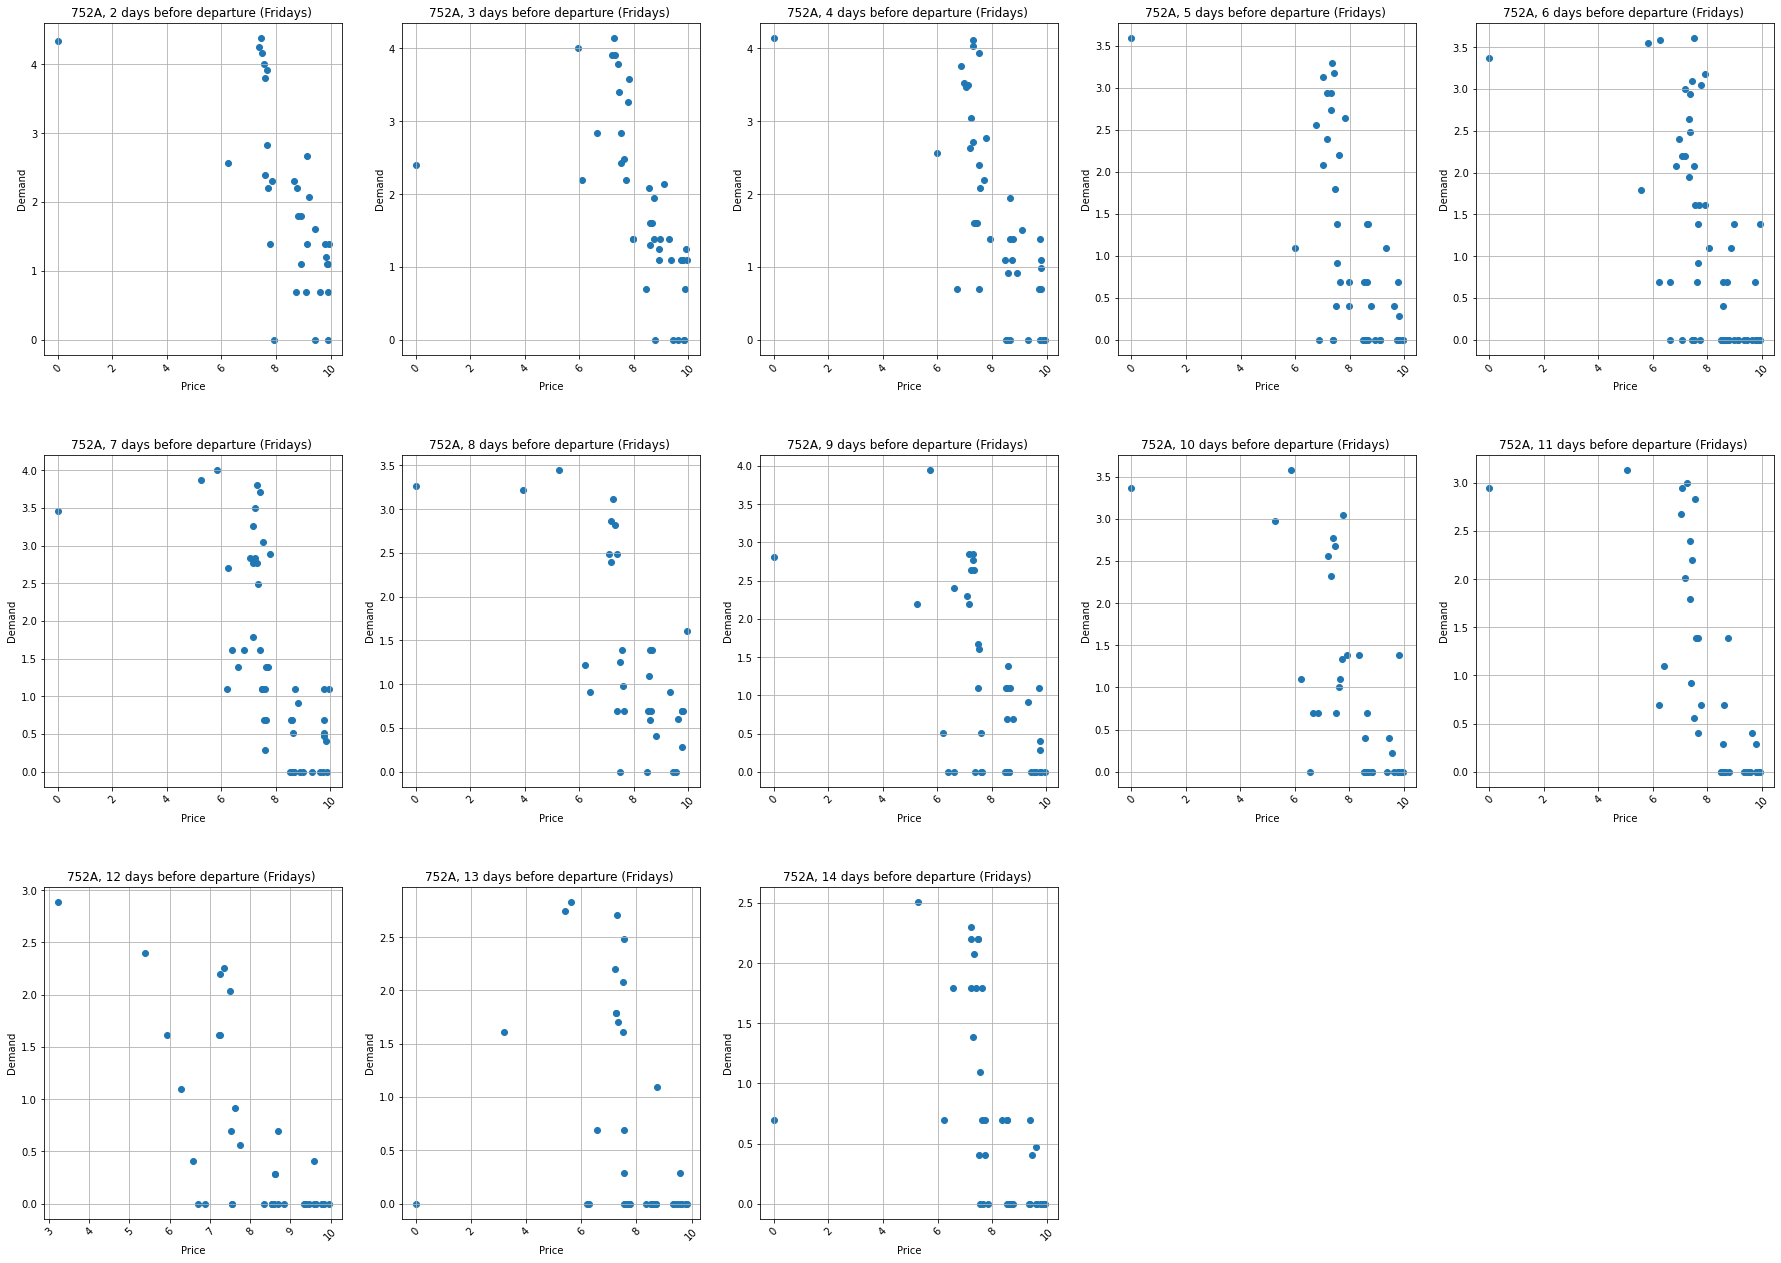

In [4]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'

plots.scatter_plot(log_lin_prices.loc[train_name].loc[wk_day], log_shift_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day, 'linear PED', save=True)

## Ensemble of Linear Regression Models

In [5]:
%%time
r2_df=pd.DataFrame(data=None, columns=prices.columns, index=mu_ind, dtype="float").sort_index()
pred_demand_df=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float").sort_index()
relined_demand_df=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float").sort_index()
A_df=pd.DataFrame(data=None, columns=prices.columns, index=demand.index, dtype="float").sort_index()
B_df=pd.DataFrame(data=None, columns=prices.columns, index=demand.index, dtype="float").sort_index()
for num in uniq_train_num:
    for wk_day in wk_days_mask:
        for day in log_lin_prices.columns:
            if not((len(log_lin_prices.loc[num].loc[wk_day][day].dropna())==0) | (len(log_shift_demand.loc[num].loc[wk_day][day].dropna())==0)):
                
                mask=~np.isnan(log_shift_demand.loc[num].loc[wk_day][day].astype(np.float64))
                
                r2, demand_pred, line_reg=model_evaluation.validation_model(log_lin_prices.loc[num].loc[wk_day][day][mask], log_shift_demand.loc[num].loc[wk_day][day][mask])
                
                r2_df.loc[num].loc[wk_day][day]=r2
                
                pred_demand_df.loc[num].loc[wk_day][day][mask]=demand_pred
                relined_demand_df.loc[num].loc[wk_day][day][mask]=np.exp(demand_pred)-1           
                A_df.loc[num, wk_day].T.loc[day]=line_reg.intercept_
                B_df.loc[num, wk_day].T.loc[day]=line_reg.coef_[0]

Wall time: 2min 31s


In [6]:
r2_df.to_csv(r'Experiments\Surrogate modeling\Data\r2_df.csv')
pred_demand_df.to_csv(r'Experiments\Surrogate modeling\Data\pred_demand_df.csv')
relined_demand_df.to_csv(r'Experiments\Surrogate modeling\Data\relined_demand_df.csv')
A_df.to_csv(r'Experiments\Surrogate modeling\Data\A_df.csv')
B_df.to_csv(r'Experiments\Surrogate modeling\Data\B_df.csv')

In [7]:
r2_df = pd.read_csv(r'Experiments\Surrogate modeling\Data\r2_df.csv', index_col=[0, 1])
r2_df.columns.name='days'
r2_df.columns=r2_df.columns.astype(int)

pred_demand_df = pd.read_csv(r'Experiments\Surrogate modeling\Data\pred_demand_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
pred_demand_df.columns.name='days'
pred_demand_df.columns=pred_demand_df.columns.astype(int)

relined_demand_df = pd.read_csv(r'Experiments\Surrogate modeling\Data\relined_demand_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
relined_demand_df.columns.name='days'
relined_demand_df.columns=relined_demand_df.columns.astype(int)

A_df = pd.read_csv(r'Experiments\Surrogate modeling\Data\A_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
A_df.columns.name='days'
A_df.columns=A_df.columns.astype(int)

B_df = pd.read_csv(r'Experiments\Surrogate modeling\Data\B_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
B_df.columns.name='days'
B_df.columns=B_df.columns.astype(int)

In [ ]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'

plots.predicted_scatter_plot(log_lin_prices.loc[train_name].loc[wk_day], log_shift_demand.loc[train_name].loc[wk_day], 
                       pred_demand_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day, 'linear surrogate PED', save=True)

In [9]:
exp_A_df=pd.DataFrame(data=np.exp(np.float64(A_df)), columns=A_df.columns, index=A_df.index, dtype="float")
relined_dem_df=exp_A_df*np.power(mean_p-min_df+1., B_df)-1.

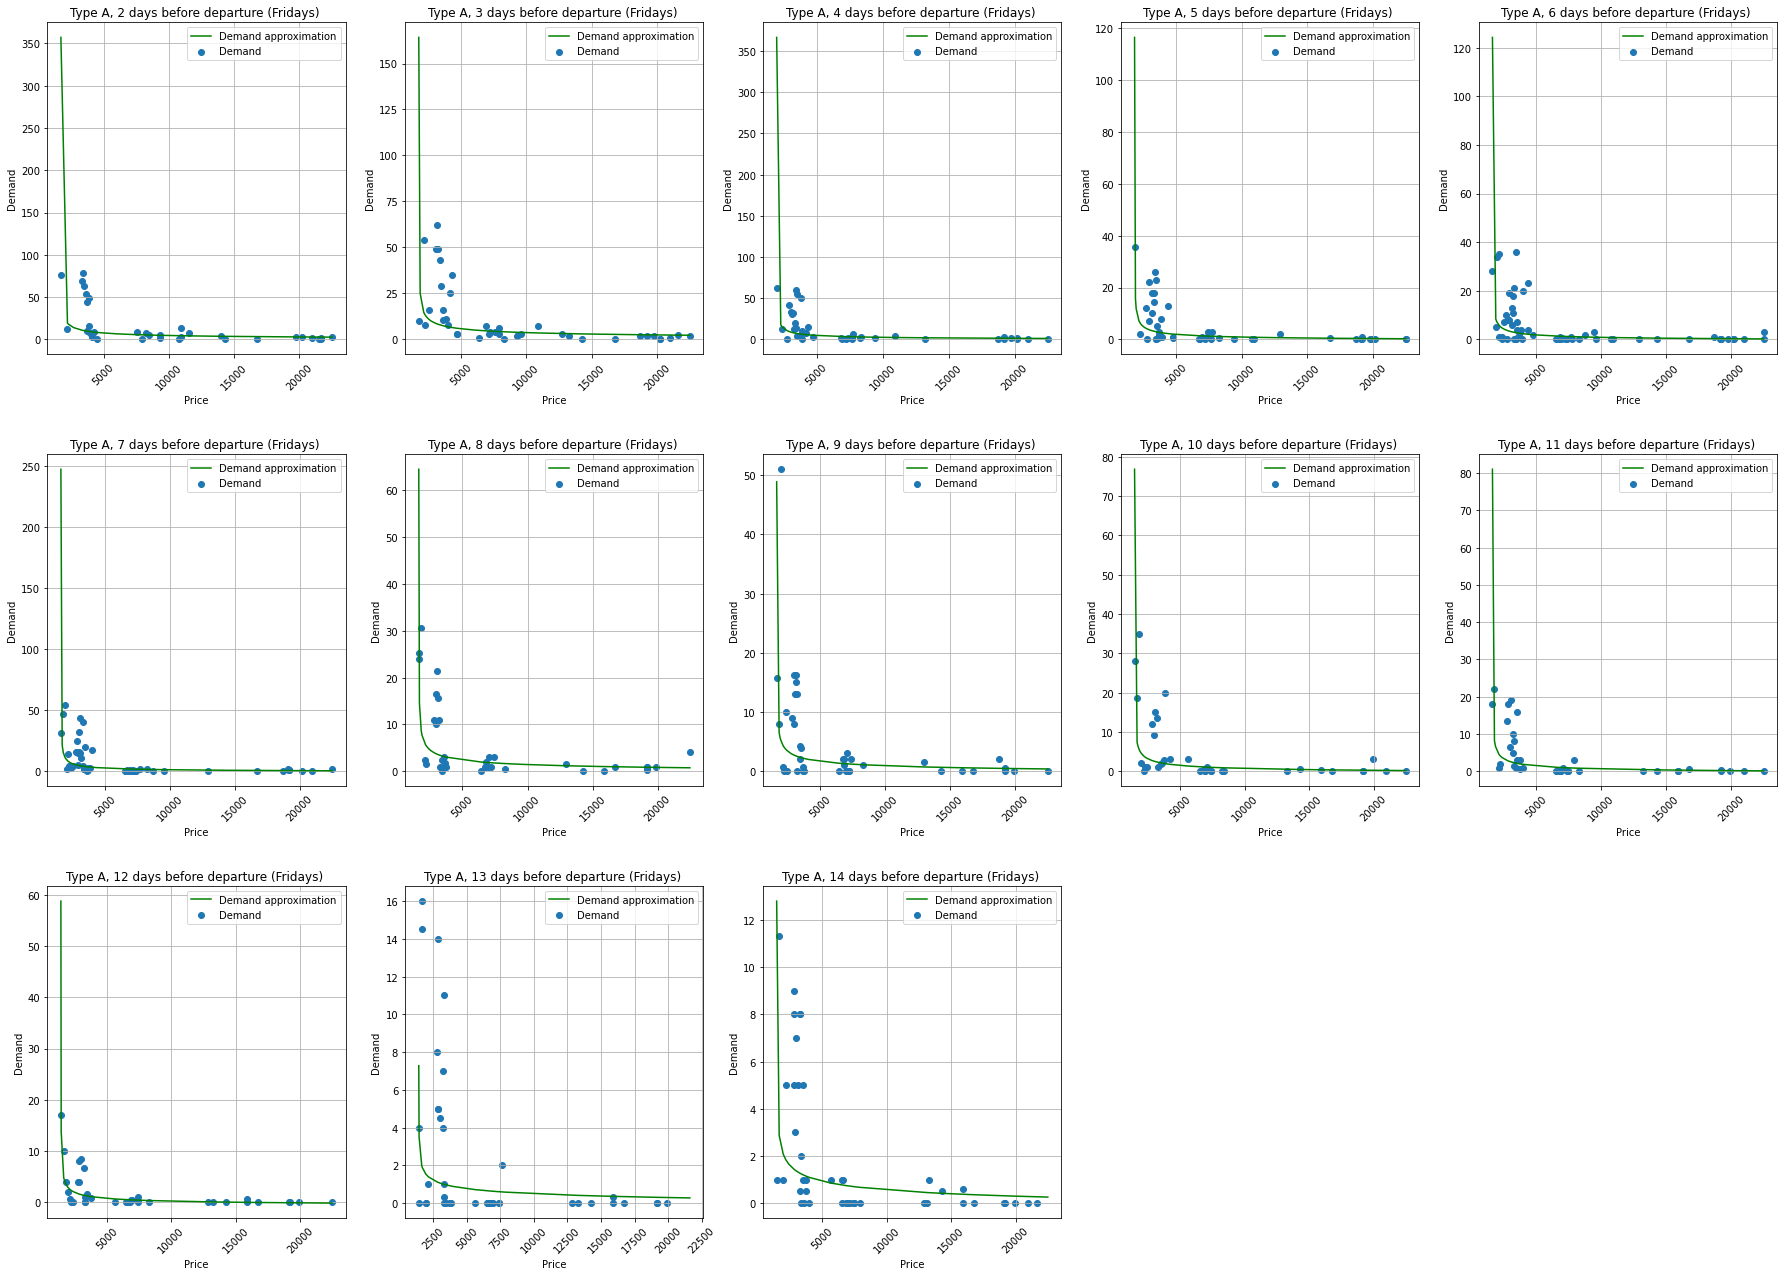

In [10]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'

plots.predicted_relined_scatter_plot(mean_p.loc[train_name].loc[wk_day], mean_d.loc[train_name].loc[wk_day], 
                       relined_dem_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day, 'relined PED model', train_type="Type A", save=True)

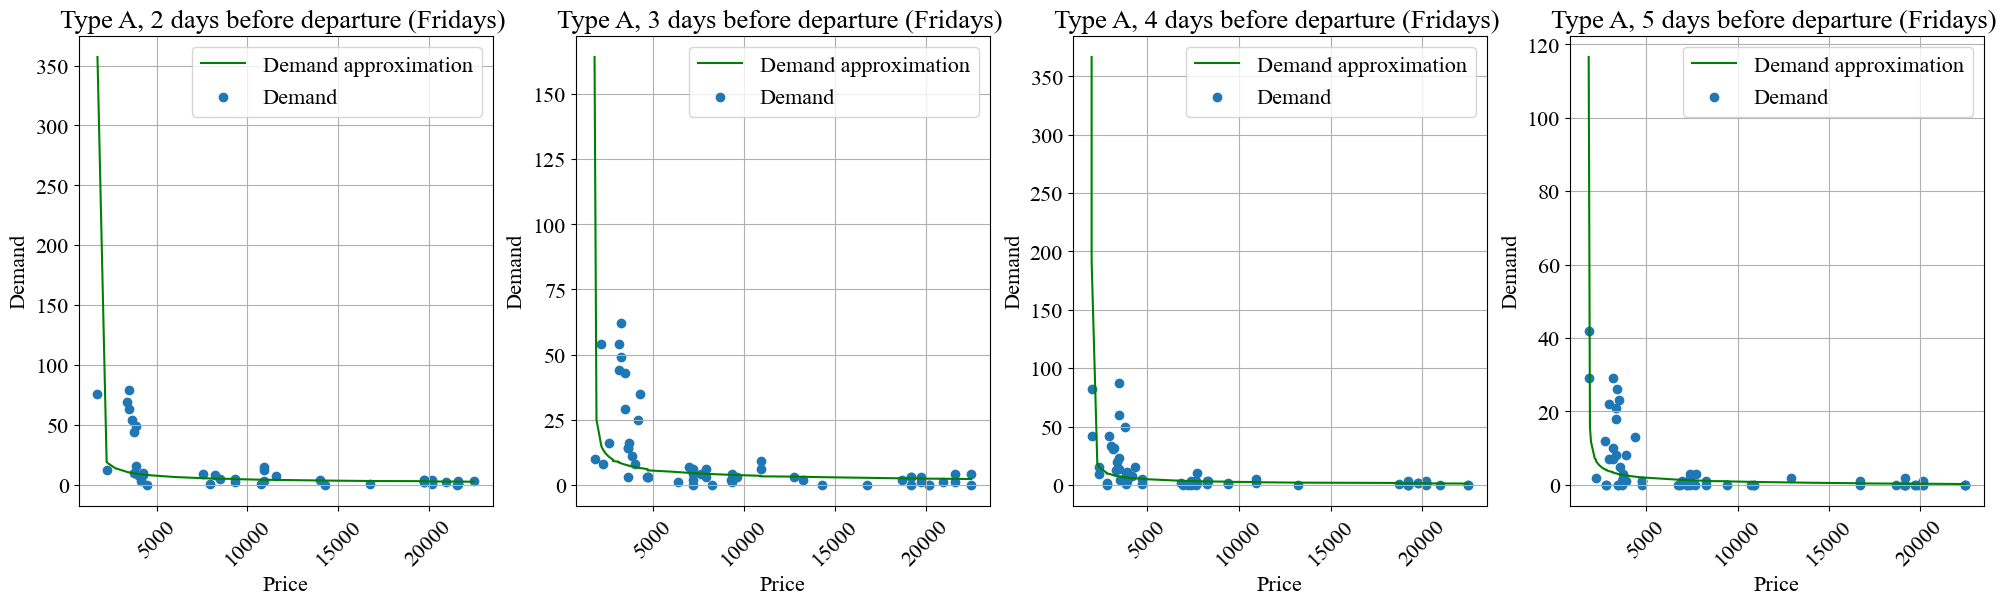

In [11]:
days=np.arange(2, 6)
train_name='752А'
wk_day='Friday'

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
plots.predicted_relined_scatter_plot(prices.loc[train_name].loc[wk_day], demand.loc[train_name].loc[wk_day], 
                       relined_dem_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day, 'relined PED model', train_type="Type A", save=False)
plt.show()

## Residuals of the models

In [12]:
epsilon=mean_d-relined_dem_df
epsilon=epsilon.mask(np.isinf(epsilon)).fillna(np.nan)
relativ_epsilon=epsilon/relined_dem_df 
relativ_epsilon=relativ_epsilon.mask(np.isinf(relativ_epsilon)).fillna(np.nan)
abs_eps=np.abs(epsilon)

In [ ]:
days=np.arange(2, 6)
train_name='752А'
wk_day='Friday'

plots.eps_hists(relativ_epsilon.loc[train_name].loc[wk_day, :14], days, train_name+' '+wk_day, 'residuals hist', train_type="Type A", save=False)
plt.show()

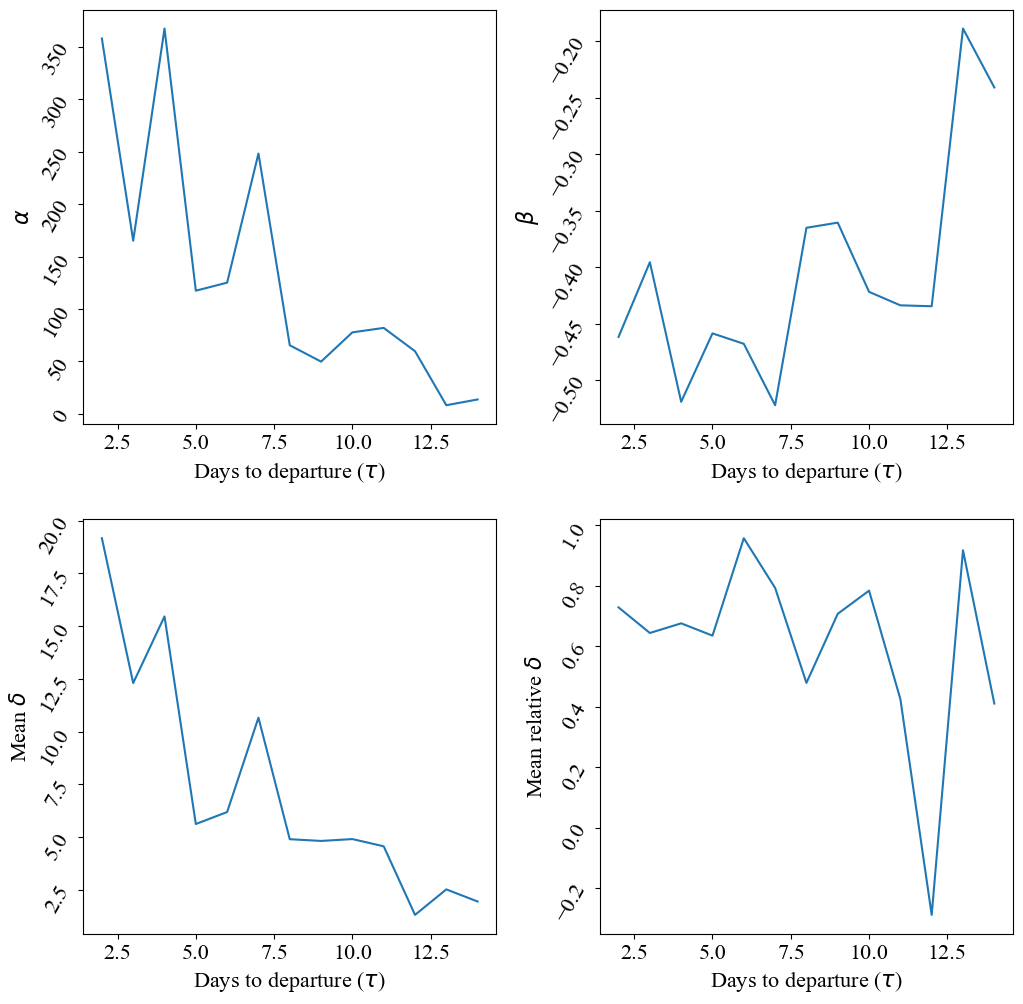

In [14]:
train_name='752А'
wk_day='Friday'

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.23)

plot_data_list=list([exp_A_df.loc[train_name].loc[wk_day, :14].mean(axis=0), B_df.loc[train_name].loc[wk_day, :14].mean(axis=0), 
                     abs_eps.loc[train_name].loc[wk_day, :14].mean(axis=0), relativ_epsilon.loc[train_name].loc[wk_day, :14].mean(axis=0)])
ylabels_list=list([r'${\alpha}$', r'${\beta}$', r'Mean ${\delta}$', 
                  r'Mean relative ${\delta}$'])
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for i, ax in enumerate(axes.flat):
    plot_data_list[i].plot(ax=ax)
    ax.set_ylabel(ylabels_list[i])
    ax.set_xlabel(r'Days to departure ($\tau$)')
    ax.tick_params(axis='y', labelrotation=60)
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
plt.show()

# Optimization

## Price constraints

In [15]:
train_num='752А'
index=['B1', 'B2', 'C1', 'C2']
general_mean_pr_list=dict()
for i, cl in enumerate(index):
    general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_num].groupby('class'))[1][i]).ravel()

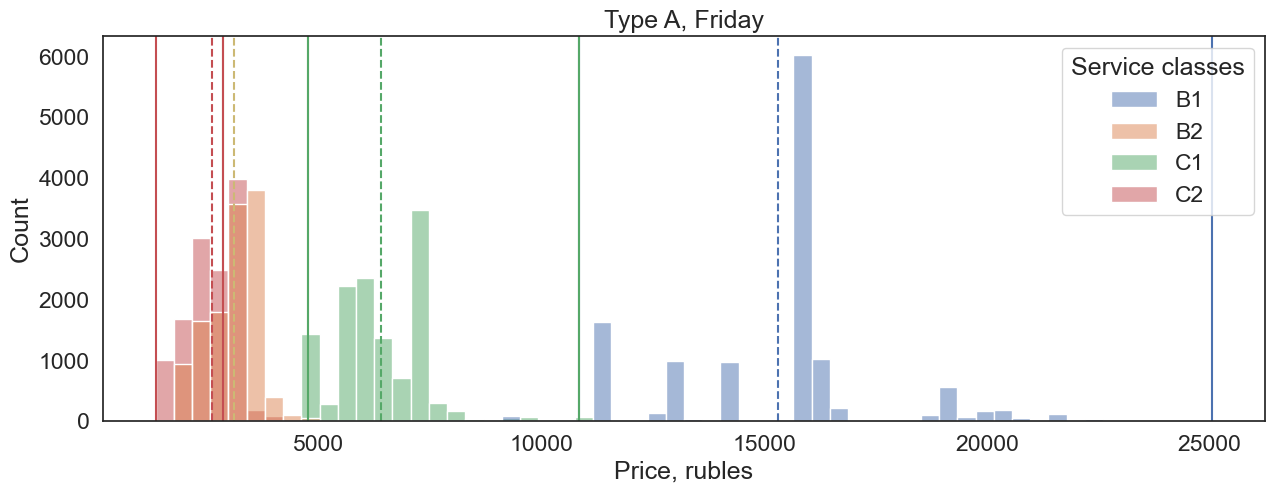

In [16]:
train_type='Type A'
wk_day='Friday'
gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
mean_val_prices_ser=gmp_df.mean(axis=1)
sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
max_price_cons=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc['B1'].max())
min_price_cons=(max_price_cons.sort_values(ascending=True).shift().fillna(gmp_df.loc['C2'].min())-1).sort_index()
colors=['b', 'y', 'g', 'r']
sns.set(rc={'figure.figsize':(15,5)}, style="white", font_scale=1.5)
g=sns.histplot(gmp_df.T)
plt.xlabel('Price, rubles')
leg = g.axes.get_legend()
new_title = 'Service classes'
leg.set_title(new_title)
plt.title(train_type+', '+wk_day)
for i, j in enumerate(index):
    plt.axvline(mean_val_prices_ser.loc[j], color=colors[i], linestyle='--')
    plt.axvline(max_price_cons.loc[j], color=colors[i])
    plt.axvline(min_price_cons.loc[j], color=colors[i])
plt.show()

## Monte Carlo model validation

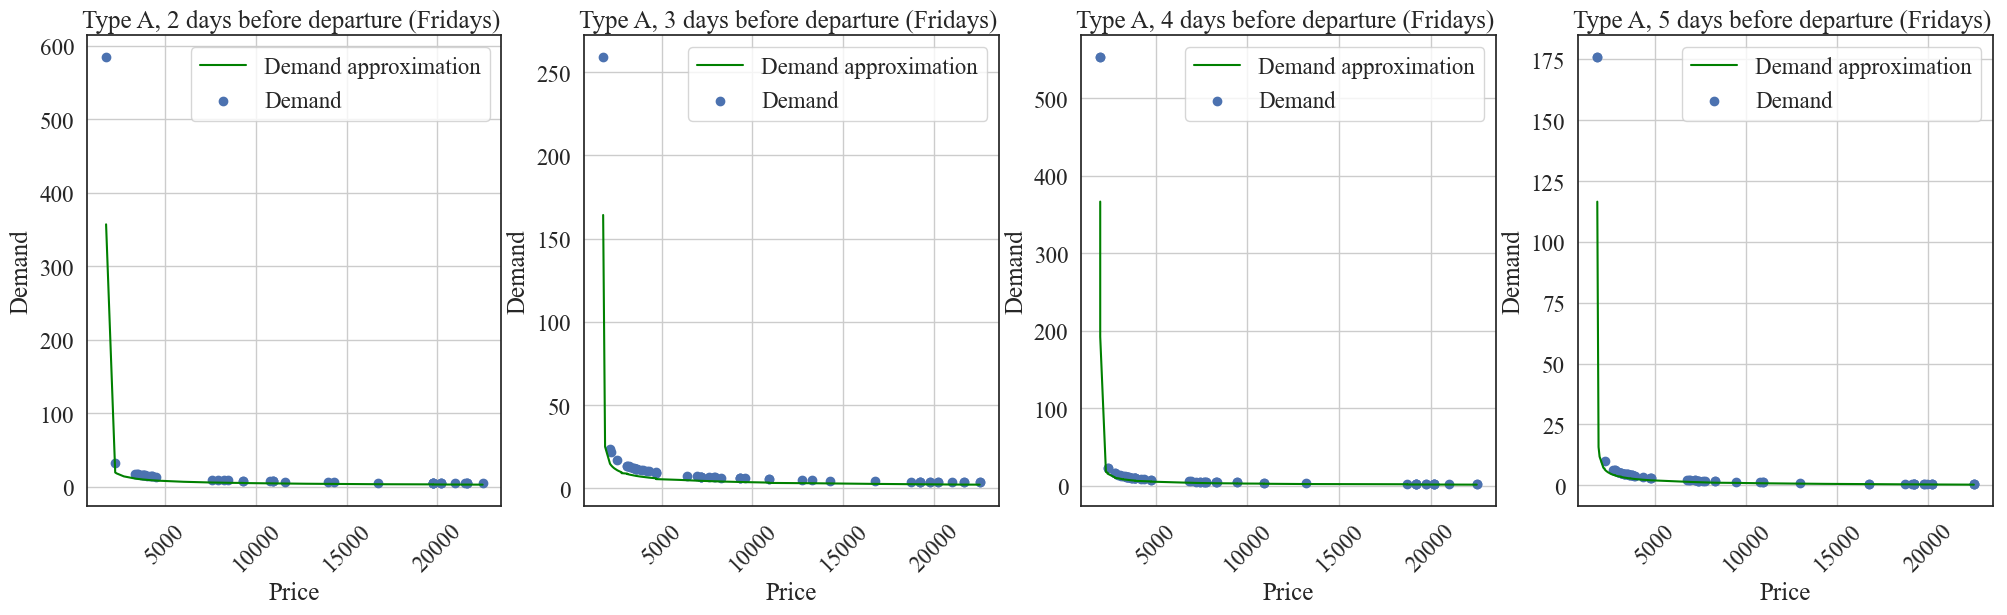

Wall time: 4.78 s


In [17]:
%%time
days=np.arange(2, 6)
train_names=list(['752А'])
train_name=train_names[0]
wk_days=list(['Friday'])
wk_day=wk_days[0]
days_to_dept=13
num_classes=len(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
arg_shape=(num_classes, days_to_dept)
min_p=np.tile(np.array(min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0])
B=np.tile(np.array(B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
A=np.tile(np.array(exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
val_prices=prices.loc[train_name].loc[wk_day, :14][~np.isnan(demand.loc[train_name].loc[wk_day, :14])]
val_demand=demand.loc[train_name].loc[wk_day, :14][~np.isnan(prices.loc[train_name].loc[wk_day, :14])]
val_list=list()
val_errors=list()
for i in range(100):
    val_eps=list()
    for k in range(4):
        for day in range(2, days_to_dept+2):
            rel_eps_arr=np.array(relativ_epsilon.loc[train_name].loc[wk_day, day])
            rel_eps_arr=rel_eps_arr[~np.isnan(rel_eps_arr)]
            val_eps.append(EmpiricalDistribution(rel_eps_arr).rvs(1))
            val_errors.append(val_eps)
        val_eps=np.array(val_eps).ravel()
        relined_val_dem_df=(exp_A_df.loc[train_name].loc[wk_day, :14]*np.power(val_prices-min_df.loc[train_name].loc[wk_day, :14]+1., B_df.loc[train_name].loc[wk_day, :14])-1.)*(1+val_eps.T)
        val_list.append(relined_val_dem_df.T.values)
        val_eps=list()
mean_val_list=np.mean(val_list, axis=0)
mean_val_df=relined_val_dem_df.copy()
for i in range(2, 14):
    mean_val_df[i]=mean_val_list[i-2]
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
plots.predicted_relined_scatter_plot(prices.loc[train_name].loc[wk_day], mean_val_df, 
                       relined_dem_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day, 'validation PED model', train_type="Type A", save=False)
plt.show()

## Optimization algorithm

In [ ]:
%%time

trains=[['752А', 'Thursday'], ['752А', 'Saturday'], ['752А', 'Tuesday'], ['752А', 'Monday'], ['752А', 'Wednesday'], ['752А', 'Wednesday']]
days_to_dept=13
main_dict=dict()
wk_days_dict=dict()
res_dict=dict()
popsize=5

for train_nd in trains:
    train_name=train_nd[0]
    wk_day=train_nd[1]
    print(train_name)
    print(wk_day)
    num_classes=len(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
    arg_shape=(num_classes, days_to_dept)
    min_p=np.tile(np.array(min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0]).ravel()
    B=np.tile(np.array(B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
    A=np.tile(np.array(exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0]) #
    class_names=np.sort(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
    integrality=list()
    for i in range(len(min_p)):
        integrality.append(True)
    integrality=np.array(integrality)
    general_mean_pr_list=dict()
    for i, cl in enumerate(class_names):
        general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_name].groupby('class'))[1][i]).ravel()
    gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
    mean_val_prices_ser=gmp_df.mean(axis=1)
    sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
    price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
    max_price=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc[gmp_df.index[0]].max())
    min_price=(max_price.sort_values(ascending=True).shift().fillna(gmp_df.loc[gmp_df.index[-1]].min())+1).sort_index()
    max_price=np.tile(max_price.values.reshape(-1,1), arg_shape[1]).ravel()
    min_price=np.tile(min_price.values.reshape(-1,1), arg_shape[1]).ravel()
    min_price[min_price<min_p]=min_p[min_price<min_p]
    max_price[min_price>max_price]=min_price[min_price>max_price]
    bounds = Bounds(min_price, max_price, keep_feasible = True) # keep_feasible=False
    max_con=np.array(places.loc[train_name].loc[wk_day, arg_shape[1]+1].groupby('class').apply(np.nanmean))
    min_con=np.ones(arg_shape[0])
    opt_prices=list()
    opt_eps=list()
    opt_rev=list()
    iterations=100
    i=iterations
    errors=0 
    while i>0:
        try:
            eps=list()
            for k in range(4):
                for day in range(2, days_to_dept+2):
                    rel_eps_arr=np.array(relativ_epsilon.loc[train_name].loc[wk_day, day])
                    rel_eps_arr=rel_eps_arr[~np.isnan(rel_eps_arr)]
                    eps.append(EmpiricalDistribution(rel_eps_arr).rvs(1))
            eps=np.array(eps).ravel()
            optim_f=optim_fun(A, min_p, B, eps, arg_shape)
            nlc = NonlinearConstraint(optim_f.f_con, min_con, max_con, keep_feasible=True)
            min_res =  differential_evolution(optim_f.revenue, bounds, constraints=(nlc), popsize=popsize)
            if min_res.success==False:
                go_to_except=1/0
            opt_prices.append(min_res.x)
            opt_eps.append(eps)
            opt_rev.append(min_res.fun)
            i-=1
            errors=0
            clear_output(wait=True)
            print(train_name)
            print(wk_day)
            print('Number of iterations: ', str(iterations-i))
            print('Found errors: ', str(errors))
        except Exception:
            errors+=1
            clear_output(wait=True)
            print(train_name)
            print(wk_day)
            print('Number of iterations: ', str(iterations-i))
            print('Found errors: ', str(errors))
            if errors>=100:
                traceback.print_exc()
                break
            else:
                traceback.print_exc()
                continue
    res_dict['prices']=opt_prices
    res_dict['eps']=opt_eps
    res_dict['rev']=opt_rev
    wk_days_dict[wk_day]=res_dict
    main_dict[train_name]=wk_days_dict
    with open(r'Experiments/Surrogate modeling/Data/Optim'+train_name+'_'+wk_day+'_'+str(popsize)+'.npy', 'wb') as f:
        np.save(f, np.array(opt_prices))
        np.save(f, np.array(opt_eps))
        np.save(f, np.array(opt_rev))

## Validation of optimization results. Estimation of optimal prices, demand and revenue.

In [ ]:
train_num='780A'
day='Thursday'

opt_prices=main_dict[train_num][day]['prices']
opt_eps=main_dict[train_num][day]['eps']

mean_opt_pr = np.mean(opt_prices, axis=0).reshape(arg_shape)
mean_opt_rev = -1*np.mean(opt_rev)

def validate_demand(x, A, min_p, B, eps):
    dem = np.sum(np.array((A*np.power(x-min_p+1., B)-1.)*(1.+eps)).reshape(arg_shape), axis=1)
    return dem

def revenue(x, A, min_p, B, eps):
    rev = -1.*np.sum(x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps)))
    return rev

val_dem_list=list()
val_rev_list=list()
for pr, ep in zip(opt_prices, opt_eps):
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)
    
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)

mean_val_rev=-1*np.mean(val_rev_list)
mean_val_dem=np.mean(val_dem_list, axis=0)
print('Mean validation revenue', mean_val_rev)
print('Mean validation demand', mean_val_dem)
print('Tickets', max_con)
print('Optimal prices >= min prices?', set(min_price<=mean_opt_pr.ravel()))
print('Optimal prices <= max prices?', set(max_price>=mean_opt_pr.ravel()))

rus_rel_rev=mean_d.loc[train_num].loc[day, :arg_shape[1]+1]*mean_p.loc[train_num].loc[day, :arg_shape[1]+1]
rus_rel_rev=np.sum(rus_rel_rev.groupby('class').mean()).sum()

print('Revenue of Russian Railways', rus_rel_rev)
print('Revenue update, %:', ((mean_val_rev-rus_rel_rev)/rus_rel_rev)*100)

In [48]:
with open(r'Experiments\Surrogate modeling\Data\Optim\752A_Friday_5.npy', 'wb') as f:
    np.save(f, np.array(opt_prices))
    np.save(f, np.array(opt_eps))
    np.save(f, np.array(opt_rev))

In [ ]:
with open(r'Experiments\Surrogate modeling\Data\Optim\752A_Friday_5.npy', 'rb') as f:
    opt_prices_de_14 = np.load(f)
    opt_eps_de_14 = np.load(f)
    opt_rev_de_14 = np.load(f)

In [62]:
train_names=list(['752A'])
train_name=train_names[0]
train_num=train_name
wk_day=list(['Friday'])
days_to_dept=13
day=wk_day[0]

num_classes=len(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
arg_shape=(num_classes, days_to_dept)

min_p=np.tile(np.array(min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0]).ravel()
B=np.tile(np.array(B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
A=np.tile(np.array(exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])

class_names=np.sort(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
        
general_mean_pr_list=dict()

for i, cl in enumerate(class_names):
    general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_name].groupby('class'))[1][i]).ravel()

gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
mean_val_prices_ser=gmp_df.mean(axis=1)
sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
max_price=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc[gmp_df.index[0]].max())
min_price=(max_price.sort_values(ascending=True).shift().fillna(gmp_df.loc[gmp_df.index[-1]].min())+1).sort_index()
max_price=np.tile(max_price.values.reshape(-1,1), arg_shape[1]).ravel()
min_price=np.tile(min_price.values.reshape(-1,1), arg_shape[1]).ravel()

min_price[min_price<min_p]=min_p[min_price<min_p]
max_price[min_price>max_price]=min_price[min_price>max_price]
        
max_con=np.array(places.loc[train_name].loc[wk_day, arg_shape[1]+1].groupby('class').apply(np.nanmean))
min_con=np.ones(arg_shape[0])

opt_prices=opt_prices_de_14
opt_eps=opt_eps_de_14

mean_opt_pr = np.mean(opt_prices, axis=0).reshape(arg_shape)
mean_opt_rev = -1*np.mean(opt_rev_de_14)

def validate_demand(x, A, min_p, B, eps):
    dem = np.sum(np.array((A*np.power(x-min_p+1, B)-1.)*(1.+eps)).reshape(arg_shape), axis=1)
    return dem

def revenue(x, A, min_p, B, eps):
    rev = -1.*np.sum(x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps)))
    return rev

val_dem_list=list()
val_rev_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)
    
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)

mean_val_rev=-1*np.nanmean(val_rev_list)
mean_val_dem=np.nanmean(val_dem_list, axis=0)

print('Mean validation revenue', mean_val_rev)
print('Mean validation demand', mean_val_dem)
print('Tickets', max_con)
print('Optimal prices >= min prices?', set(min_price<=mean_opt_pr.ravel()))
print('Optimal prices <= max prices?', set(max_price>=mean_opt_pr.ravel()))
rus_rel_rev=mean_d.loc[train_num].loc[day, :arg_shape[1]+1]*mean_p.loc[train_num].loc[day, :arg_shape[1]+1]
rus_rel_rev=np.sum(rus_rel_rev.groupby('class').mean()).sum()

print('Revenue of Russian Railways', rus_rel_rev)
print('Revenue update, %:', ((mean_val_rev-rus_rel_rev)/rus_rel_rev)*100)

Mean validation revenue 1201939.8729126465
Mean validation demand [ 12.96376073  32.92997253  29.9426658  257.99413214]
Tickets [ 15.7037037   36.26923077  41.42307692 258.76      ]
Optimal prices >= min prices? {True}
Optimal prices <= max prices? {True}
Revenue of Russian Railways 1248440.117471278
Revenue update, %: -3.724667599821923


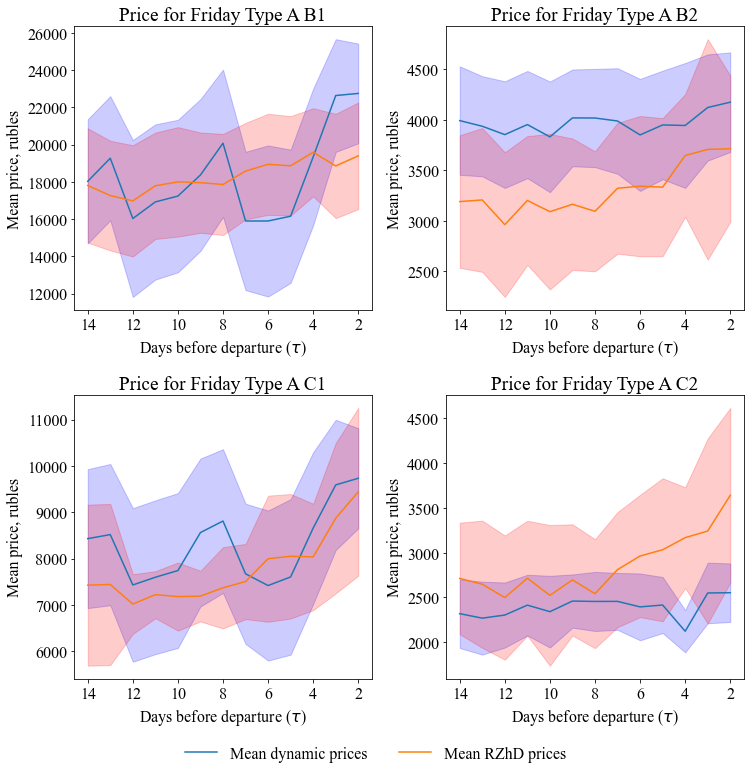

In [54]:
from matplotlib.ticker import MaxNLocator

train_type='Type A'

ev_mean_pr=np.mean(opt_prices_de_14, axis=0).reshape(4, 13)
ev_std_pr=np.std(opt_prices_de_14, axis=0).reshape(4, 13)

pl_std=ev_mean_pr+ev_std_pr
mi_std=ev_mean_pr-ev_std_pr

rgd_mean_pr=np.array(mean_p.loc[train_num].loc[day, :14].groupby('class').apply(np.nanmean, axis=0))
rgd_std_pr=np.array(mean_p.loc[train_num].loc[day, :14].groupby('class').apply(np.nanstd, axis=0))

rgd_pl_std=rgd_mean_pr+rgd_std_pr
rgd_mi_std=rgd_mean_pr-rgd_std_pr


fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)

cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_pr[cl])
    ax.fill_between(days_b_d, pl_std[cl], mi_std[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_pr[cl])
    ax.fill_between(days_b_d, rgd_pl_std[cl], rgd_mi_std[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean price, rubles')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Price for '+day+' '+train_type +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.figlegend([r'Mean dynamic prices',
               r'Mean RZhD prices'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)

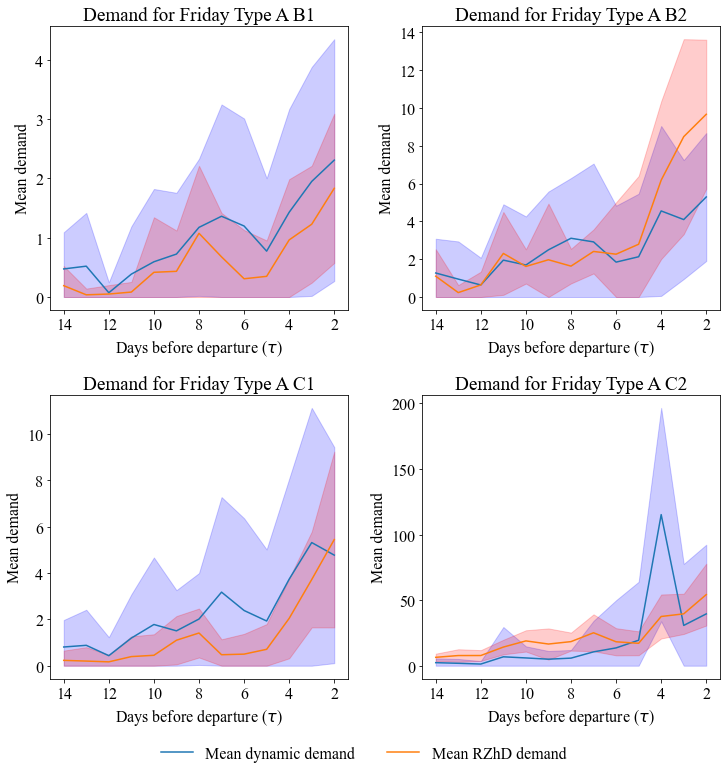

In [55]:
from matplotlib.ticker import MaxNLocator

train_type='Type A'

def validate_demand(x, A, min_p, B, eps):
    dem = np.array((A*np.power(x-min_p+1, B)-1.)*(1.+eps))
    return dem

val_dem_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)

ev_mean_dem=np.mean(val_dem_list, axis=0).reshape(4, 13)
ev_std_dem=np.std(val_dem_list, axis=0).reshape(4, 13)

pl_std_dem=ev_mean_dem+ev_std_dem
mi_std_dem=ev_mean_dem-ev_std_dem
pl_std_dem[pl_std_dem<0]=0.
mi_std_dem[mi_std_dem<0]=0.

rgd_mean_dem=np.array(mean_d.loc[train_num].loc[day, :14].groupby('class').apply(np.nanmean, axis=0))
rgd_std_dem=np.array(mean_d.loc[train_num].loc[day, :14].groupby('class').apply(np.nanstd, axis=0))

rgd_pl_std_dem=rgd_mean_dem+rgd_std_dem
rgd_mi_std_dem=rgd_mean_dem-rgd_std_dem

for i, _ in enumerate(rgd_pl_std_dem):
    rgd_pl_std_dem[i][rgd_pl_std_dem[i]<0]=0.
    rgd_mi_std_dem[i][rgd_mi_std_dem[i]<0]=0.

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)

cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_dem[cl])
    ax.fill_between(days_b_d, pl_std_dem[cl], mi_std_dem[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_dem[cl])
    ax.fill_between(days_b_d, rgd_pl_std_dem[cl], rgd_mi_std_dem[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean demand')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Demand for '+day+' '+train_type +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.figlegend([r'Mean dynamic demand',
               r'Mean RZhD demand'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)

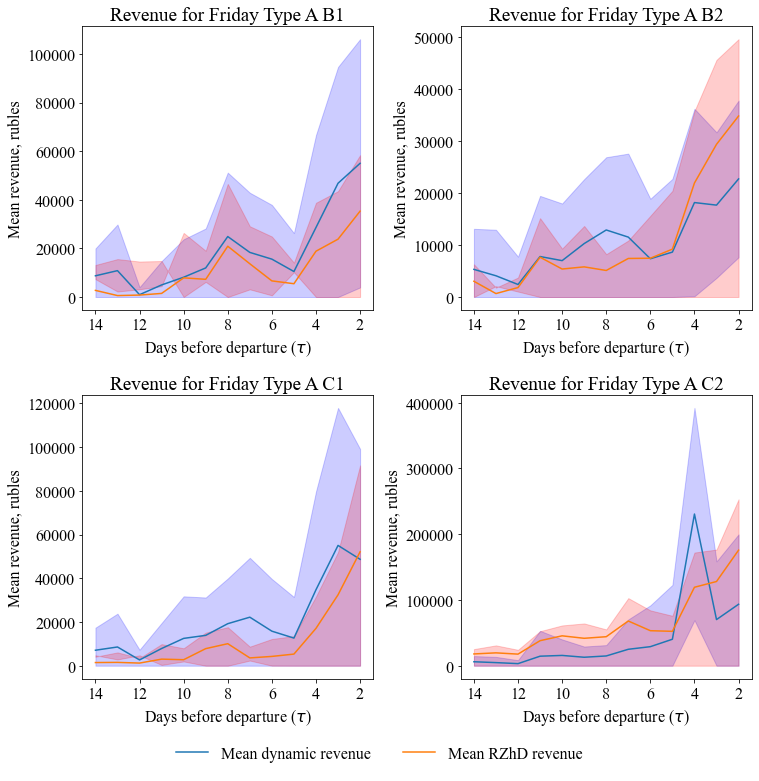

In [56]:
from matplotlib.ticker import MaxNLocator

train_type='Type A'

def revenue(x, A, min_p, B, eps):
    rev = x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps))
    return rev
val_rev_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)
ev_mean_rev=np.mean(val_rev_list, axis=0).reshape(4, 13)
ev_std_rev=np.std(val_rev_list, axis=0).reshape(4, 13)
pl_std_rev=ev_mean_rev+ev_std_rev
mi_std_rev=ev_mean_rev-ev_std_rev
pl_std_rev[pl_std_rev<0]=0.
mi_std_rev[mi_std_rev<0]=0.
rgd_mean_rev=mean_d.loc[train_num].loc[day, :14]*mean_p.loc[train_num].loc[day, :14]
rgd_std_rev=np.array(rgd_mean_rev.groupby('class').apply(np.nanstd, axis=0))
rgd_mean_rev=np.array(rgd_mean_rev.groupby('class').apply(np.nanmean, axis=0))
rgd_pl_std_rev=rgd_mean_rev+rgd_std_rev
rgd_mi_std_rev=rgd_mean_pr-rgd_std_rev
for i, _ in enumerate(rgd_pl_std_dem):
    rgd_pl_std_rev[i][rgd_pl_std_rev[i]<0]=0.
    rgd_mi_std_rev[i][rgd_mi_std_rev[i]<0]=0.
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)
cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_rev[cl])
    ax.fill_between(days_b_d, pl_std_rev[cl], mi_std_rev[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_rev[cl])
    ax.fill_between(days_b_d, rgd_pl_std_rev[cl], rgd_mi_std_rev[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean revenue, rubles')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Revenue for '+day+' '+train_type +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.figlegend([r'Mean dynamic revenue',
               r'Mean RZhD revenue'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)

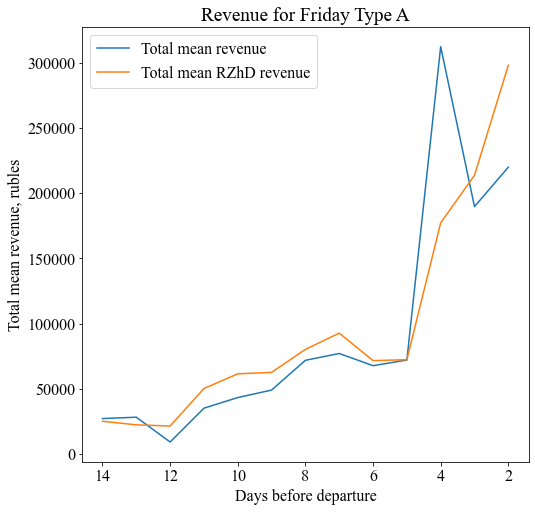

In [57]:
rgd_mean_sum_rev=np.nansum(list(rgd_mean_rev), axis=0)
revv=np.nansum(list(ev_mean_rev), axis=0)
fig, ax = plt.subplots(1, figsize=(8, 8))
cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
ax.plot(days_b_d, revv, label='Total mean revenue')
ax.plot(days_b_d, rgd_mean_sum_rev, label='Total mean RZhD revenue')
ax.set_ylabel('Total mean revenue, rubles')
ax.set_xlabel('Days before departure')
ax.set_title('Revenue for '+day+' '+train_type)
ax.legend(loc='upper left')
ax.invert_xaxis()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [58]:
pd.DataFrame({'Opt_sum_rev': revv, 'RZhD_sum_rev': rgd_mean_sum_rev, 'Opt_conf': np.sum(ev_std_rev, axis=0), 'RZhD_conf': np.sum(rgd_std_rev, axis=0)}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
Opt_sum_rev,219817.429483,189620.888862,312186.096968,71986.094095,67687.773694,77027.401640,71800.304056,48974.411014,43255.032136,35086.941728,9158.066937,28202.320379,27137.111919
RZhD_sum_rev,297956.630000,213624.882197,177157.533838,72255.733712,71577.920824,92642.186397,80166.508148,62574.229697,61436.657222,50188.530909,21441.824444,22323.273333,25094.206748
Opt_conf,222893.604638,213209.909553,262407.864313,131298.016632,120526.507647,113133.789192,77453.415163,62205.609818,70139.751553,71637.150199,18352.378857,51772.975609,37918.865999
RZhD_conf,154655.516452,104022.311444,101062.887903,51692.901189,65257.572408,58812.304449,47397.682811,49509.960261,43469.169857,31807.084238,13119.056659,18721.893695,17906.155091
